<a href="https://colab.research.google.com/github/ramonvluz/deteccao-de-fraude-em-cartoes-de-credito/blob/main/Deteccao_de_Fraude_em_Cart%C3%B5es_de_Credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detecção de Fraudes em Transações de Cartão de Crédito**

Fraudes em cartões de crédito são um grande problema para bancos e fintechs. No Brasil, mais de 12 milhões de pessoas foram vítimas de fraudes financeiras no último ano, causando um prejuízo de R$ 1,8 bilhão.

Com o crescimento do comércio eletrônico, a detecção eficiente de fraudes em tempo real é crucial para proteger consumidores e instituições financeiras.

Investir em Inteligência Artificial para detectar fraudes em transações de cartão de crédito representa uma oportunidade valiosa em Data Science, com potencial para economizar milhões de Reais.

O desafio é aprimorar constantemente os algoritmos para prevenir ou detectar transações fraudulentas de forma mais eficaz, reduzindo falsos positivos e prejuízos.

## Objetivo do Projeto

O objetivo do projeto é desenvolver modelos preditivos precisos para distinguir entre transações legítimas e fraudulentas, usando algoritmos de Machine Learning como Regressão Logística e Árvores de Decisão.

Antes de construir o modelo, faremos análises para lidar com dados faltantes, verificar correlações, fazer descrições estatísticas, e garantir o balanceamento de classes. Em seguida, iniciaremos a construção e comparação de modelos de Machine Learning para resolver o problema.

Com tudo isso em mente, começaremos importando e explicando os dados antes de avançar no projeto.

# **Importando oa Bibliotecas e os Dados**

Os [dados utilizados](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) foram fornecidos por empresas europeias de cartão de crédito, representando dois dias de transações com 492 fraudes em cerca de 290 mil transações, resultando em um desbalanceamento acentuado, com fraudes representando apenas 0,17%.

As características do dataset são todas numéricas e foram descaracterizadas para proteger a privacidade, representadas por [V1, V2, V3... V28], passando por uma transformação chamada Análise de Componentes Principais (PCA) para redução da dimensionalidade enquanto mantém a informação essencial. Os componentes da PCA são os mesmos das colunas originais [V1, V2, V3... V28].

In [336]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [337]:
# Importando os dados para um df

ccredito = '/content/drive/MyDrive/Colab Notebooks/Detecção de Fraudes em Cartões de Crédito/creditcard.csv'

df = pd.read_csv(ccredito)

## **Criando um Conjunto de Validação**


In [338]:
# Criando o conjunto de validação

validacao = df.sample(frac=0.15, random_state=0)

In [339]:
# Excluindo do df os dados usados no novo conjunto

df = df.drop(validacao.index)

In [340]:
# Verificando o conjunto de dados após a separação

print(f"Dimensão do Conujunto de Treino: {df.shape}")
print(f"Dimensão do Conujunto de Validação: {validacao.shape}")

Dimensão do Conujunto de Treino: (242086, 31)
Dimensão do Conujunto de Validação: (42721, 31)


- 15% dos dados do DataFrame original foram separados para um conjunto de validação. Após criar e ajustar os modelos de Machine Learning, utilizarei esse dados para testar e avaliar sua eficácia com dados novos, nunca antes visto pelos modelos.

## **Dicionário de Variáveis**

- Time: intervalo de tempo em segundos entre cada transação.
- Amount: valor da transação.
- Class: indica se a transação é fraudulenta (1) ou legítima (0).
- V1, V2, V3...V28: variáveis ocultas por questões de privacidade.

# **Análise Exploratória**

In [341]:
# Visualizando o df

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- Observando as primeiras entradas, consigo notar que:

  - A transformação PCA anonimiza e numera as colunas em um intervalo de -1 a 1.
  - As colunas Time e Amount permanecem com seus valores originais.
  - A coluna Class é a minha variável alvo, onde:
    - 0: representa uma transação real.
    - 1: representa uma transação fraudulenta.

In [342]:
# Visualizando a descrição estatística dos dados

print(df.describe())

                Time             V1             V2             V3  \
count  242086.000000  242086.000000  242086.000000  242086.000000   
mean    94857.597379       0.001456      -0.000800      -0.001004   
std     47490.660832       1.956513       1.654883       1.514580   
min         0.000000     -56.407510     -72.715728     -33.680984   
25%     54234.000000      -0.920406      -0.598659      -0.893374   
50%     84747.000000       0.019230       0.064567       0.177607   
75%    139362.000000       1.316034       0.803174       1.026561   
max    172792.000000       2.451888      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  242086.000000  242086.000000  242086.000000  242086.000000   
mean        0.000647      -0.000986      -0.001196      -0.000033   
std         1.417228       1.366284       1.326879       1.223095   
min        -5.683171     -42.147898     -26.160506     -43.557242   
25%        -0.848236      -0.6936

- Ao analisar as informações acima, observamos que:

  - As variáveis V1-V28 e Time não apresentam discrepâncias.
  - Na variável Amount, destacam-se:
    - Média das transações: 88.61
    - Mediana: 22
    - Desvio padrão: 247.65
    - 75% dos valores são abaixo de 77.58
    - Valor máximo da transação: 19656.53

In [343]:
# Verificando os valores nulos

df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

- Verifiquei se há valores nulos no conjunto de dados, o que exigiria ações como o preenchimento com zeros, mediana ou a exclusão das linhas afetadas, dependendo do problema. Isso é necessário porque modelos de Machine Learning não podem lidar com valores nulos. Felizmente o conjunto de dados não possui valores ausentes, então não precisarei fazer nenhum tratamento.

- Agora irei verificar como está as distribuições de classes, se estiverem muito desbalanceadas, será nescessário fazer algum tratamento.   
  - Para isso, irei fazer um plot de contagem para os 0s e 1s, e também averiguar a porcentagem de valores considerados reais e fraudulentos.

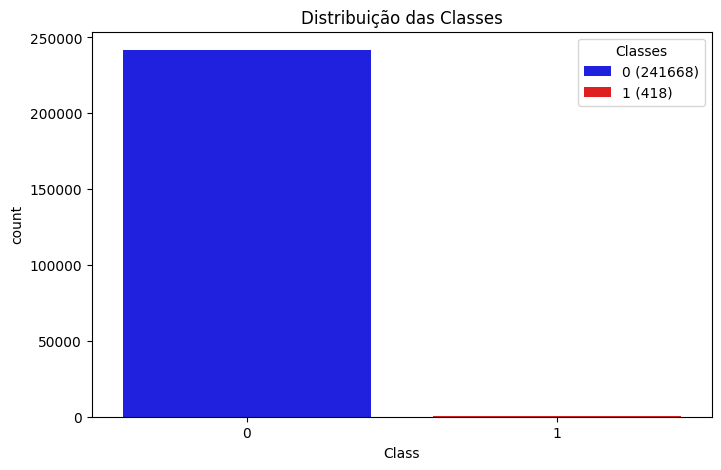

In [344]:
# Gráfico de barras para as classes

colors = {'Class 0': 'blue', 'Class 1': 'red'}

# Criando uma figura e eixo

fig, ax = plt.subplots(figsize=(8, 5))

# Plotando o gráfico de barras
sns.countplot(x=df["Class"], ax=ax, hue=df["Class"], palette=colors.values(), legend=False)
ax.set_title("Distribuição das Classes")

# Contando as ocorrências de cada classe
class_counts = df["Class"].value_counts()

# Criando a legenda personalizada
legend_labels = [f'{cls} ({count})' for cls, count in class_counts.items()]
ax.legend(handles=ax.patches, labels=legend_labels, title="Classes")

plt.show()

In [345]:
# Verificando o balanceamento do conjunto de dados

df["Class"].value_counts()

perc_trans_reais = (df[df["Class"]==0].shape[0]/df.shape[0])*100
perc_trans_fraudulentas = (df[df["Class"]==1].shape[0]/df.shape[0])*100

print(f"Transações reais representam: {perc_trans_reais:.4f}% do conjunto de dados")
print(f"Transações fraudulentas representam: {perc_trans_fraudulentas:.4f}% do conjunto de dados")

Transações reais representam: 99.8273% do conjunto de dados
Transações fraudulentas representam: 0.1727% do conjunto de dados


- Com as análises feitas acima, percebo que:

  - Existem 241.668 transações classificadas como 0 (reais) e apenas 418 classificadas como 1 (fraudulentas).
  - As transações reais representam aproximadamente 99,83% do total.
  - As fraudes representam apenas 0,17% do total de dados.

- Com esses pontos destacados, fica claro o grande desbalanceamento entre as classes. Um rebalanceamento será realizado posteriormente, por enquanto continuarei com as análises.

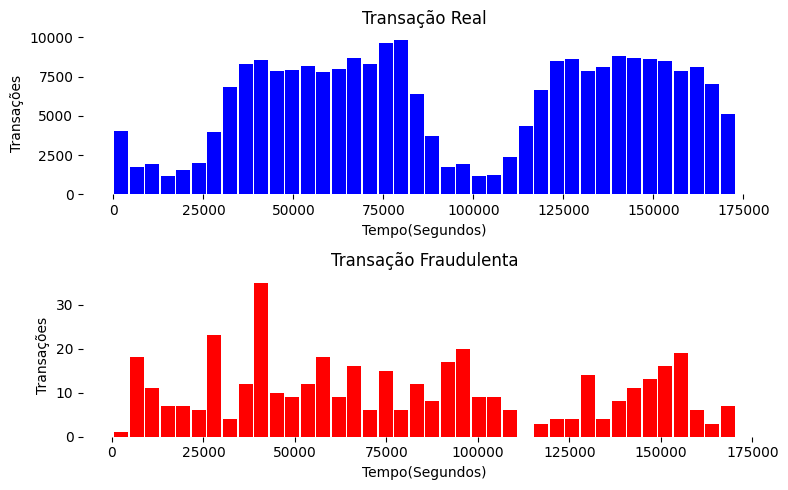

In [346]:
# Plotando um histograma da variável Time pela Classes

# Criando uma figura e eixo

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))

for axis in ax:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.set_xlabel("Tempo(Segundos)")
    axis.set_ylabel("Transações")

ax[0].hist(df['Time'][df['Class']==0], bins=40, rwidth=0.9, color='b')
ax[0].set_title("Transação Real", )

ax[1].hist(df['Time'][df['Class']==1], bins=40, rwidth=0.9, color='r')
ax[1].set_title("Transação Fraudulenta")

plt.xlabel("Tempo(Segundos)")
plt.ylabel("Transações")
plt.tight_layout()

- Na célula anterior, foram criados 2 histogramas: um para as transações reais e outro para as fraudulentas, ambos mostrando a distribuição ao longo do tempo para identificar possíveis padrões ou informações. No entanto, não foi identificado nada relevante.

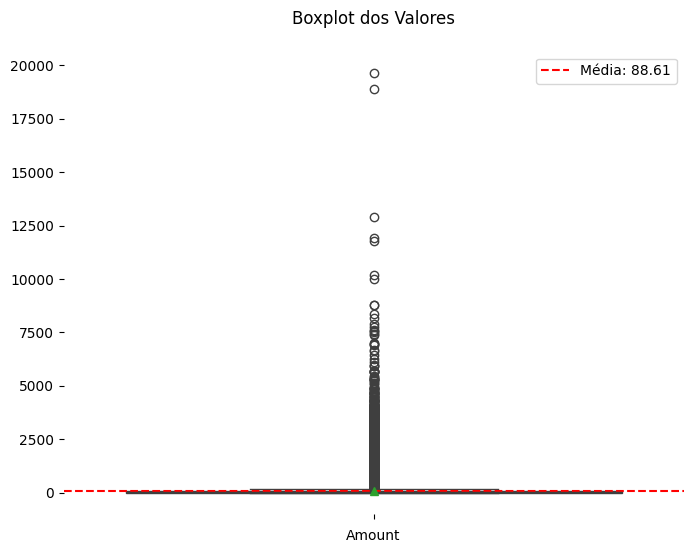

In [347]:
# Verificano valores outliers na variável Amount

# Criando uma figura e eixo
fig, ax = plt.subplots(figsize=(8, 6))

# Removendo as bordas do gráfico
sns.despine(ax=ax, left=True, bottom=True)

# Criando o boxplot com média visível
sns.boxplot(data=df['Amount'], ax=ax, showmeans=True)

# Adicionando título e rótulos dos eixos
ax.set_title("Boxplot dos Valores", pad=20)
ax.set_xlabel("Amount")
ax.set_ylabel("")

# Adicionando uma linha horizontal para a média
mean_value = df['Amount'].mean()
ax.axhline(mean_value, color='r', linestyle='--', label=f'Média: {mean_value:.2f}')
ax.legend()

plt.show()

<ipython-input-348-507b8522d322>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Class"].astype(str), y=df["Amount"], showmeans=True, ax=ax, palette=palette)


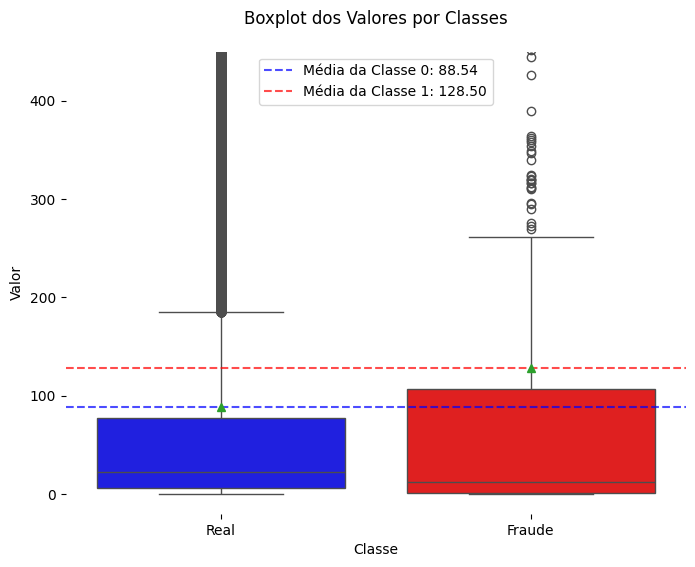

In [348]:
# Verificano valores outliers nas classes

# Criando uma figura e eixo
fig, ax = plt.subplots(figsize=(8, 6))

# Removendo as bordas do gráfico
sns.despine(ax=ax, left=True, bottom=True)

# Criando o boxplot com média visível e especificando as cores
palette = {'0': 'blue', '1': 'red'}
sns.boxplot(x=df["Class"].astype(str), y=df["Amount"], showmeans=True, ax=ax, palette=palette)

# Definindo os limites do eixo y
plt.ylim((-20, 450))

# Definindo os rótulos das classes
plt.xticks([0, 1], ["Real", "Fraude"])

# Adicionando título e rótulos dos eixos
ax.set_title("Boxplot dos Valores por Classes", pad=20)
ax.set_xlabel("Classe")
ax.set_ylabel("Valor")

# Adicionando linhas horizontais para a média de cada classe com cores específicas
class_means = df.groupby('Class')['Amount'].mean()
colors = ['blue', 'red']
for i, mean_value in enumerate(class_means):
    ax.axhline(mean_value, color=colors[i], linestyle='--', label=f'Média da Classe {i}: {mean_value:.2f}', alpha=0.7)

# Ajustando a legenda para evitar duplicatas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show()

- Ao analisarmos os boxplots, visualizamos claramente a presença de outliers na variável Amount, tanto nas classes reais quanto nas fraudulentas. Também é possível observar a média dos dados indicada por uma seta verde.

- Para finalizar a análise exploratória de dados, irei criar um histograma de Amount para a classe fraudulenta (1) e também farei uma descrição estatística de Amount para cada classe individualmente. Isso ajudará a identificar se há alguma correlação entre os valores outliers e a classe correspondente.

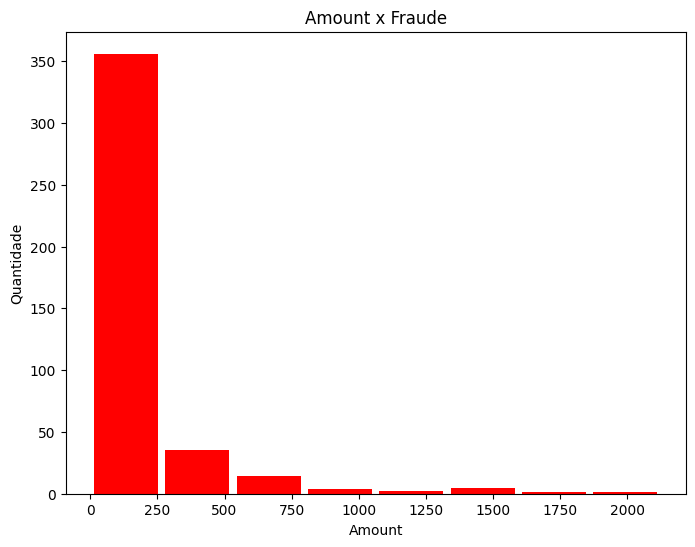

In [349]:
# Plotaando histograma de "Amount" para a classe fraudulenta (1)

fig, ax = plt.subplots(figsize=(8,6))

amount_fraude = df['Amount'][df['Class'] == 1]

ax.hist(amount_fraude, bins=8, rwidth=0.9, color='r')
ax.set_xlabel("Amount")
ax.set_ylabel("Quantidade")
ax.set_title("Amount x Fraude")
plt.locator_params(axis='x', nbins=10)
plt.show()

In [350]:
# Verificando descrição estatística para cada classes

real_0 = df['Amount'][df['Class'] == 0]
fraude_1 = df['Amount'][df['Class'] == 1]

print("Valores Reais:")
print(real_0.describe())
print("--------------------------------")
print("Valores Fraudulentos:")
print(fraude_1.describe())

Valores Reais:
count    241668.000000
mean         88.543443
std         247.613919
min           0.000000
25%           5.700000
50%          22.000000
75%          77.500000
max       19656.530000
Name: Amount, dtype: float64
--------------------------------
Valores Fraudulentos:
count     418.000000
mean      128.496722
std       267.731154
min         0.000000
25%         1.000000
50%        11.855000
75%       106.812500
max      2125.870000
Name: Amount, dtype: float64


- Com essas últimas análises, posso observar quê:

  - A maioria das compras fraudulentas está entre 0 e 250.
  - A média dos valores de transações reais e fraudulentas é bem diferente.
    - Média das transações reais: 88,54.
    - Média das transações fraudulentas: 128,49, uma diferença de 45%.
    
  A partir desses pontos, o modelo de Machine Learning pode considerar um valor mais alto como fraude, o que pode ser um problema. Agora, começaremos a preparar nossos dados para aplicar a um modelo.

# **Modelagem e Preparação de Dados**

## Padronização dos Dados

A padronização de dados, ou normalização, é um processo comum no pré-processamento de dados que transforma os valores das variáveis para uma escala comum. O objetivo é garantir que todas as variáveis tenham a mesma ordem de grandeza, eliminando diferenças de escala entre elas.

A padronização envolve calcular a média e o desvio padrão dos dados, subtraindo a média de cada valor e dividindo pelo desvio padrão. Isso resulta em uma distribuição com média zero e desvio padrão um.

Padronizarei as colunas Amount e Time. E como a variável Amount contém outliers, utilizarei a função StandardScaler da biblioteca Scikit-Learn para lidar com esse problema.

In [351]:
# Criando uma cópia do df original

df_std = df.copy()

In [352]:
# Instanciando a função

std_scaler = StandardScaler()

In [353]:
# Aplicando a transformação

df_std["std_amount"] = std_scaler.fit_transform(df_std["Amount"].values.reshape(-1, 1))
df_std["std_time"] = std_scaler.fit_transform(df_std["Time"].values.reshape(-1, 1))

In [354]:
# Excluindo as colunas "Time" e "Amount"

df_std.drop(columns=["Time", "Amount"], axis=1, inplace=True)

- Exclui as colunas "Time" e "Amount", pois as mesmas tiveram os seu valores padronizados nas novas variáveis "std_time" e "std_amount".

In [355]:
# Visualizando os padronizados

df_std.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.246341,-1.997399
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.346945,-1.997399
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.171178,-1.997378
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140872,-1.997378
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.075195,-1.997357


- Agora após a transformação conseguimos perceber que os dados de "std_amount" e "std_time" estão no mesmo padrão da variáveis V1-V28, o que significa que estão todas em uma mesma escala.

## **Separando os Dados em Treino e Teste**

- Com os dados padronizados, agora posso dividir o conjunto entre **Treino** (75%) e **Teste** (25%). Farei essa divisão antes de balancear os dados, usando apenas os dados de treino para o balanceamento. Assim, podemos avaliar a qualidade do nosso modelo durante a validação.

- Usarei a função **train_test_split** com dois parâmetros para melhorar a separação dos dados: Stratify e Shuffle.

  - **Stratify**: Mantém a distribuição das classes ou rótulos em ambos os conjuntos de treinamento e teste.
  -  **Shuffle**: Embaralha os dados antes da divisão, evitando qualquer viés ou ordem nos dados.

In [356]:
# Separando os dados

x = df_std.drop("Class", axis=1)
y = df_std["Class"]

In [357]:
# Dividindo os dados entre Treino e Teste

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, shuffle=True)

In [358]:
# Visualizando a proporção dos dados

print(f"Dados Totais: {df_std.shape[0]}")
print(f"Dados de Treino: {x_train.shape[0]}")
print(f"Dados de Teste: {x_test.shape[0]}")

Dados Totais: 242086
Dados de Treino: 181564
Dados de Teste: 60522


- Observamos que os dados totais são 242.086, sendo 181.564 (75%) para treino e 60.522 (25%) para teste. Com os dados separados, a próxima etapa é o balanceamento do conjunto de classes.

## Balanceamento de Classes

O balanceamento é crucial para lidar com conjuntos de dados desequilibrados, nos quais algumas classes têm um número significativamente menor de exemplos. Isso pode causar problemas durante o treinamento do modelo, levando à necessidade de técnicas de balanceamento.

Existem duas técnicas comuns:

- **Oversampling**: Aumenta a classe minoritária replicando ou gerando exemplos adicionais para igualar o número de exemplos entre as classes.
- **Undersampling**: Reduz a classe majoritária removendo exemplos para equilibrar o número de exemplos entre as classes e evitar viés em direção à classe majoritária.

Para este projeto, optei por usar o método de Undersampling da biblioteca **imblearn**, para balancear os dados.

In [359]:
# Instanciando a função do imblearn

under_sampler = RandomUnderSampler()

In [360]:
# Aplicando a transformação

x_bal, y_bal = under_sampler.fit_resample(x_train, y_train)

Class
0    313
1    313
Name: count, dtype: int64


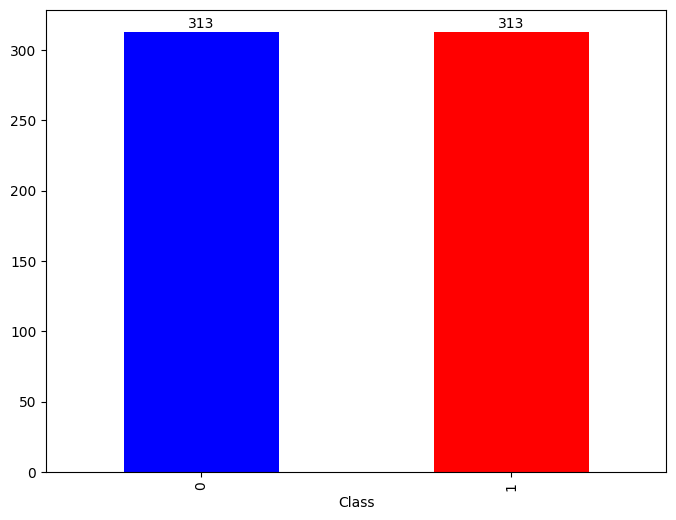

In [361]:
# Conferindo o balanceamento

value_counts = y_bal.value_counts()
print(value_counts)

# Conferindo com um gráfico de barras

fig, ax = plt.subplots(figsize=(8,6))

color_mapping = {0: 'b', 1: 'r'}
colors = [color_mapping.get(x, 'cor padrão') for x in y_bal.unique()]

ax = value_counts.plot(kind='bar', color=colors)

# Adicionando legenda para o valor de ocorrências de classe
for i in range(len(value_counts)):
    ax.text(i, value_counts[i] + 1, str(value_counts[i]), ha='center', va='bottom')

plt.show()

- Após o balanceamento, observo no gráfico como as classes estão distribuídas de maneira mais equilibrada. Esse processo ajuda a evitar o Overfitting, no qual o modelo se torna excessivamente preciso com os dados de treinamento, mas não generaliza bem para novos dados.

- A próxima etapa será plotar matrizes de correlação para os dados desbalanceados e balanceados, para verificar se houve alguma mudança.

- Em seguida, avançarei para a construção dos modelos de Machine Learning.

In [362]:
# Aplicando a correlação

corr_balanceados = x_bal.corr()
corr_desbalanceados = x_train.corr()

Text(0.5, 1.0, 'Dados Balanceados')

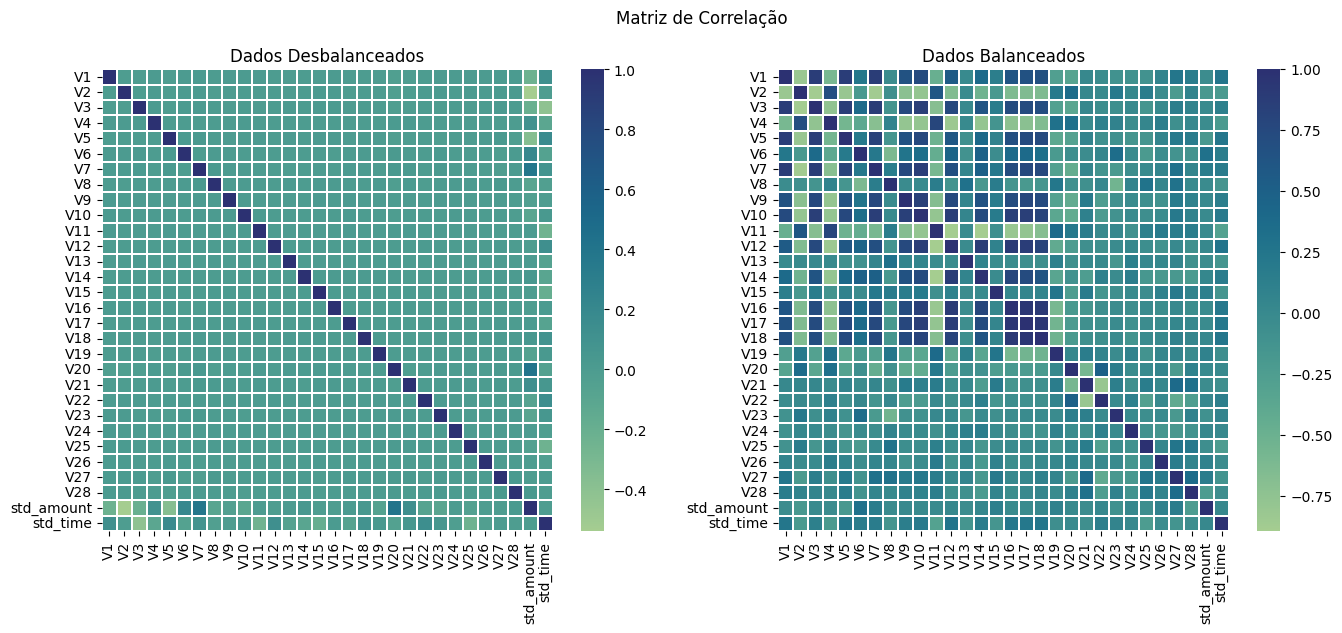

In [363]:
# Visualizando a matriz de correlação dos dados balancedos e desbalanceados

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle("Matriz de Correlação")

sns.heatmap(corr_desbalanceados, ax=ax[0], linewidth=.01, cmap="crest")
ax[0].set_title("Dados Desbalanceados")
sns.heatmap(corr_balanceados, ax=ax[1], linewidth=.01, cmap="crest")
ax[1].set_title("Dados Balanceados")

- Após o balanceamento, observo que as variáveis apresentam uma correlação mais forte do que antes. Para entender melhor, vejamos como funciona a correlação, que varia de -1 a 1:

  - Próximo de 1: correlação positiva forte, as variáveis variam na mesma direção.
  - Próximo de -1: correlação negativa forte, uma variável aumenta enquanto a outra diminui.
  - Próximo de 0: correlação fraca ou nula, sem relação linear aparente.

- Irei agora começar a trabalhar nos modelos de Machine Learning.

# **Modelos**

Machine Learning é uma área da inteligência artificial em que os computadores aprendem com dados, identificando padrões e tomando decisões sem programação direta. Nesse projeto de Detecção de Fraude em Cartão de Crédito, utilizarei de técnicas de Machine Learning para identificar padrões de fraudes e prevenir possíveis casos. Testarei dois algoritmos de classificação: a Regressão Logística e Árvore de Decisão, para determinar qual é mais eficaz.

## **Regressão Logística**

A Regressão Logística é um algoritmo de aprendizado de máquina usado para problemas de classificação. Prevê a probabilidade de uma variável pertencer a uma classe com base em variáveis independentes. É útil para problemas binários, como prever se um evento ocorrerá ou não. É usado na medicina, na área de finanças, marketing e análise de dados para tomada de decisões e previsões baseadas em dados.

### Previsão com dados de teste

In [364]:
# Criando o modelo

np.random.seed(2)
reg_log = LogisticRegression()

In [365]:
# Treinando o modelo

reg_log.fit(x_bal, y_bal)

LogisticRegression()

In [366]:
# Fazendo previsão com os dados de teste

y_predict = reg_log.predict(x_bal)
y_probability = reg_log.predict_proba(x_bal)

### Métricas de Avaliação

Relatório de Classificação:
               precision    recall  f1-score   support

           0      0.922     0.978     0.949       313
           1      0.976     0.917     0.946       313

    accuracy                          0.947       626
   macro avg      0.949     0.947     0.947       626
weighted avg      0.949     0.947     0.947       626

Acurácia: 0.947

AUC: 0.947


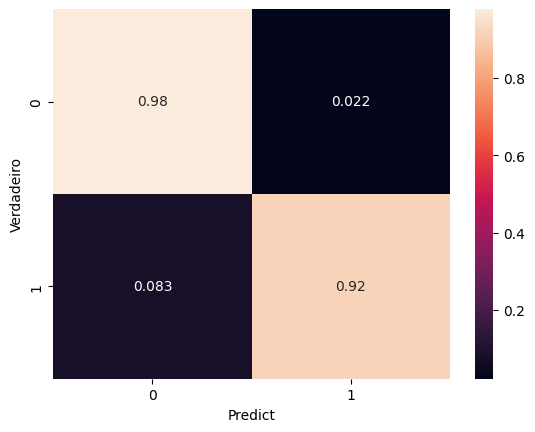

In [367]:
# Criando o relatório

print(f"Relatório de Classificação:\n {classification_report(y_bal, y_predict, digits=3)}")
print(f"Acurácia: {accuracy_score(y_bal, y_predict):.3f}\n")
print(f"AUC: {roc_auc_score(y_bal, y_predict):.3f}")

# Criando e plotando a matriz de confusão

matriz = confusion_matrix(y_bal, y_predict, normalize="true")

sns.heatmap(matriz, annot=True)
plt.xlabel("Predict")
plt.ylabel("Verdadeiro")
plt.show()

- Observando os resultados anteriores, posso apontar algumas conclusões do nosso modelo aplicado aos dados de validação:

  - O modelo previu corretamente 93% das fraudes, um valor excelente.
  - Alcançamos uma acurácia de 94%.
  - O AUC também foi de 94%.

- Quanto mais próximos de 100%, melhor são esses resultados.

### Previsão com dados de Validação

No início do projeto, reservei 15% dos dados para validar o modelo, sem usá-los nas análises. Agora irei aplicar esses dados ao modelo após padronizar as colunas Time e Amount, como feito anteriormente.

In [368]:
# Criando um cópia do df

df_validacao = validacao.copy()

In [369]:
# Fazendo a padronização

std_scaler = StandardScaler()

df_validacao["std_amount"] = std_scaler.fit_transform(df_validacao["Amount"].values.reshape(-1, 1))
df_validacao["std_time"] = std_scaler.fit_transform(df_validacao["Time"].values.reshape(-1, 1))

In [370]:
# Apagando colunas

df_validacao.drop(columns=["Amount", "Time"], axis=1, inplace=True)

In [198]:
# Visualizando o df de validação

df_validacao.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,...,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.177738,0.658372
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,...,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.321945,1.320094
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,...,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.034666,1.219742
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,...,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.838765,-0.919236
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,...,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.310490,-1.572827


- Com os dados de validação preparados, agora farei as previsões novamente.

In [371]:
# Dividindo os dados de validação em Treino e Teste

x_test = df_validacao.drop(columns="Class", axis=1)
y_test = df_validacao["Class"]

In [372]:
# Fazendo previsão com os dados de validação

y_predict1 = reg_log.predict(x_test)
y_probability1 = reg_log.predict_proba(x_test)[:, 1]

### Métricas de Avaliação

Relatório de Classificação:
               precision    recall  f1-score   support

           0      1.000     0.974     0.987     42647
           1      0.057     0.919     0.108        74

    accuracy                          0.974     42721
   macro avg      0.529     0.946     0.547     42721
weighted avg      0.998     0.974     0.985     42721

Acurácia: 0.974

AUC: 0.946


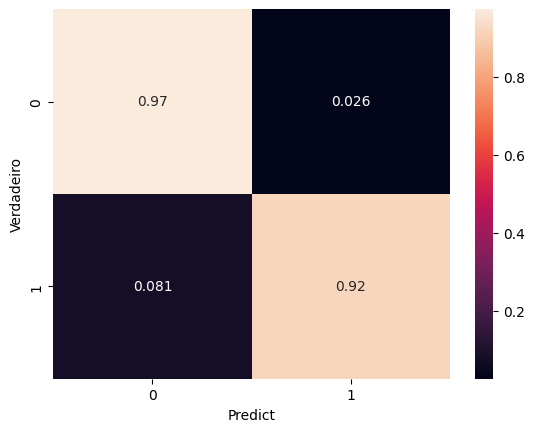

In [373]:
# Relatório de Classificação Regressão Logística

print(f"Relatório de Classificação:\n {classification_report(y_test, y_predict1, digits=3)}")
print(f"Acurácia: {accuracy_score(y_test, y_predict1):.3f}\n")
print(f"AUC: {roc_auc_score(y_test, y_predict1):.3f}")

# Criando e plotando a matriz de confusão

matrix = confusion_matrix(y_test, y_predict1, normalize="true")
sns.heatmap(matrix, annot=True)
plt.xlabel("Predict")
plt.ylabel("Verdadeiro")
plt.show()

- Comparando os resultados do modelo de Regressão Logística entre os dados **balanceados** de **teste** e os dados **desbalanceados** de **validação**, noto que:
  - A acurácia apresentou uma melhora de 94% para 97%.

  - A previsão de fraudes se manteve em 93%. Apesar de não haver uma diferença, na prática é significativo, pois indica um bom desempenho do modelo ao lidar com dados não vistos anteriormente.

## **Árvore de Decisão**

A árvore de decisão é um algoritmo de aprendizado de máquina que modela relações e decisões com base em uma estrutura de árvore. Ela divide os dados em subconjuntos específicos usando características ou atributos, até chegar a uma decisão ou previsão final. A árvore é composta por nós (testes em atributos) e ramos (resultados desses testes), com as folhas representando as classes ou valores previstos.

Durante o treinamento, o algoritmo busca as melhores características e pontos de divisão para criar subconjuntos mais puros e distintos. Uma das principais vantagens da árvore de decisão é sua interpretabilidade, permitindo visualizar e entender as decisões em cada nó. Ela também pode lidar com dados categóricos e numéricos e é útil para selecionar as características mais importantes.

As principais métricas para avaliar uma árvore de decisão são as mesmas usadas na regressão logística, aplicáveis a todos os algoritmos de classificação. A métrica mais importante depende do problema específico.

### Previsão com os dados de teste

In [202]:
# Criando o modelo

np.random.seed(2)
arv_dec = DecisionTreeClassifier(max_depth=3)

In [203]:
# Treinando o modelo

arv_dec.fit(x_bal, y_bal)

DecisionTreeClassifier(max_depth=3)

In [204]:
# Fazendo as previsões com os dados de teste

y_predict = arv_dec.predict(x_bal)
y_probability = arv_dec.predict_proba(x_bal)

### Métricas de Avaliação

- Acima, treinei e fiz previsões utilizando nosso modelo de Árvore de Decisão. Realizei alguns testes com diferentes hiperparâmetros para melhorar o desempenho do modelo, e o melhor resultado foi obtido ajustando o parâmetro max_depth. Esse parâmetro limita a profundidade máxima da árvore, referindo-se ao número de níveis ou camadas de nós, desde o nó raiz até os nós folha.

- Após vários testes, este foi o melhor resultado obtido.

Relatório de Classificação:
               precision    recall  f1-score   support

           0      0.962     0.971     0.967       313
           1      0.971     0.962     0.966       313

    accuracy                          0.966       626
   macro avg      0.966     0.966     0.966       626
weighted avg      0.966     0.966     0.966       626

Acurácia: 0.966

AUC: 0.966


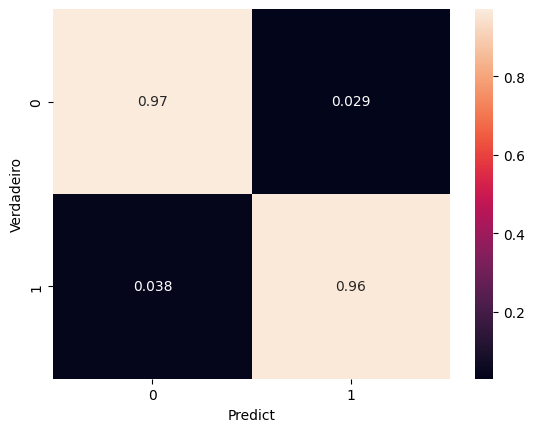

In [205]:
# Criando o relatório

print(f"Relatório de Classificação:\n {classification_report(y_bal, y_predict, digits=3)}")
print(f"Acurácia: {accuracy_score(y_bal, y_predict):.3f}\n")
print(f"AUC: {roc_auc_score(y_bal, y_predict):.3f}")

# Criando a matriz de confusão

matriz = confusion_matrix(y_bal, y_predict, normalize='true')
sns.heatmap(matriz, annot=True)
plt.xlabel("Predict")
plt.ylabel("Verdadeiro")
plt.show()

### Previsão com os dados de Validação

In [206]:
# Fazer as previsões com os dados de validaçao

y_predict2 = arv_dec.predict(x_test)
y_probability2 = arv_dec.predict_proba(x_test)[:, 1]

### Métricas de Avaliação

Relatório de Classificação:
               precision    recall  f1-score   support

           0      1.000     0.902     0.948     42647
           1      0.016     0.919     0.031        74

    accuracy                          0.902     42721
   macro avg      0.508     0.910     0.490     42721
weighted avg      0.998     0.902     0.947     42721

Acurácia: 0.902

AUC: 0.910


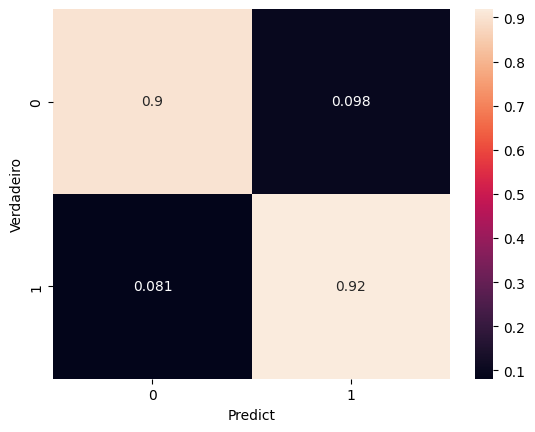

In [207]:
#Relatório de Classificação Árvore de Decisão

print(f"Relatório de Classificação:\n {classification_report(y_test, y_predict2, digits=3)}")
print(f"Acurácia: {accuracy_score(y_test, y_predict2):.3f}\n")
print(f"AUC: {roc_auc_score(y_test, y_predict2):.3f}")

#Criando a matriz de confusão

matrix = confusion_matrix(y_test, y_predict2, normalize="true")
sns.heatmap(matrix, annot=True)
plt.xlabel("Predict")
plt.ylabel("Verdadeiro")
plt.show()

- Comparando os resultados do modelo de Árvore de Decisão entre os dados **balanceados** de **teste** e os dados **desbalanceados** de **validação**, noto que:

  - A Acurácia caiu de 96% para 90%.
  - A previsão de fraude também caiu de 96% para 92%.

- Grandes indicios que o modelo de Regressão Logistica pode ser o melhor, mas somente terei a certeza assim que fizer a avaliação de desempenho dos modelos aplicando a tecnica da curva ROC (ou área sobre a curva AUC).

# **Comparando os modelos**

## Curva ROC

Para comparar os modelos e escolher o melhor, usarei a curva ROC (Receiver Operating Characteristic), uma ferramenta de avaliação de desempenho para modelos de classificação binária. A curva ROC representa graficamente a taxa de verdadeiros positivos em relação à taxa de falsos positivos, variando o ponto de corte da classificação. A área sob a curva (AUC-ROC) indica o poder discriminativo do modelo, com valores próximos de 1 indicando bom desempenho.

A curva ROC ajuda na escolha do ponto de corte ideal para equilibrar a sensibilidade e a especificidade do modelo. É amplamente utilizada para selecionar e comparar modelos de classificação.

Quanto mais próxima a curva estiver do canto superior esquerdo, melhor será o desempenho do modelo. O AUC, já calculado anteriormente, é a área sob essa curva, sendo que valores maiores indicam um modelo melhor. Com essas informações, irei comparar a Regressão Logística e a Árvore de Decisão aplicadas ao problema de Detecção de Fraude de Cartão de Crédito e averiguar qual se sairá melhor.

AUC - Regressão Logística: 0.95
AUC - Árvore de Decisão: 0.91
---------------------------------


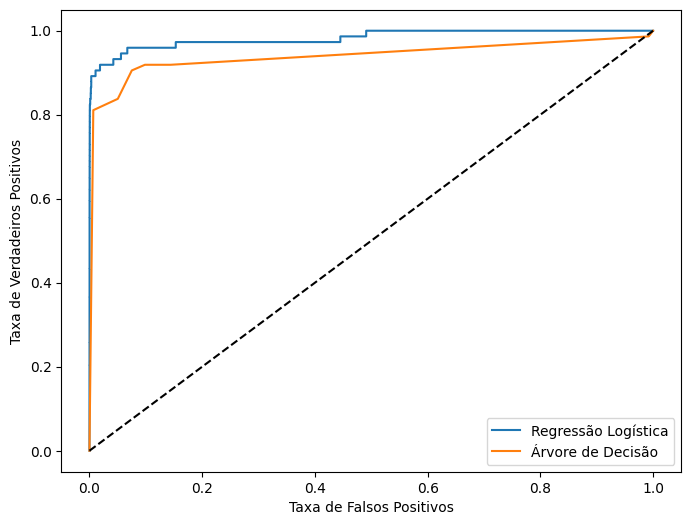

In [375]:
# Calculando as taxas de verdadeiros positivos e falsos positivos para cada modelo

fpr_modelo1, tpr_modelo1, _ = roc_curve(y_test, y_probability1)
fpr_modelo2, tpr_modelo2, _ = roc_curve(y_test, y_probability2)

# Imprimindo o AUC

print(f"AUC - Regressão Logística: {roc_auc_score(y_test, y_predict1):.2f}")
print(f"AUC - Árvore de Decisão: {roc_auc_score(y_test, y_predict2):.2f}")
print("---------------------------------")

# Plotando a curva ROC para cada modelo

plt.figure(figsize=(8, 6))
plt.plot(fpr_modelo1, tpr_modelo1, label='Regressão Logística')
plt.plot(fpr_modelo2, tpr_modelo2, label='Árvore de Decisão')
plt.plot([0, 1], [0, 1], 'k--')

# Incluindo uma legenda e rótulos nos eixos

plt.legend(loc='lower right')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.show()

- O gráfico da Curva ROC indica que a Regressão Logística é melhor, aproximando-se mais de 1. No entanto, não podemos avaliar apenas uma métrica. O Recall, que mede a capacidade de identificar corretamente as transações fraudulentas, é crucial neste problema. O modelo de Regressão Logística apresenta um Recall de 97%, enquanto na Árvore de Decisão é de 90%. Assim, a Regressão Logística é o melhor modelo para detectar fraudes em transações de cartão de crédito, vencendo tanto na Curva ROC quanto no Recall.

# **Comclusão**

Ao final do nosso projeto, tirei algumas conclusões importantes sobre todo o processo:

- Primeiramente, foi crucial entender qual era o problema que estávamos resolvendo e as medidas tomadas para proteger os dados dos clientes.

- Em relação aos dados, reservei 15% para testar o modelo no final e ver seu desempenho com dados inéditos.

- Fiz uma análise detalhada dos dados, incluindo estatísticas descritivas e gráficos para entender melhor sua distribuição.

- Preparamos os dados para os modelos de Machine Learning, aplicando transformações necessárias e rebalanceando as classes.

- Construí e avaliei modelos de Regressão Logística e Árvore de Decisão, utilizando métricas como relatórios de classificação, matrizes de confusão e a curva ROC.

- Após todas as análises, concluí que o modelo de Regressão Logística se destacou como a melhor opção para o nosso projeto.